# Hand gestures classification using a pre-trained Vision Transformer
The pre-trained model and a custom-made network are used to classify hand gestures as Peace, Thumbs-up, and Ok. The custom dataset encompasses around 100 images per class.

# Preliminaries

In [1]:
!pip install datasets

In [4]:
!pip install transformers[torch]
!pip install accelerate -U

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns

from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

import os
import numpy as np
from PIL import Image

import matplotlib as mpl
import matplotlib.pyplot as plt

import random
#from sklearn.model_selection import train_test_split

import warnings

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18

import numpy as np
from datasets import load_metric

from transformers import ViTForImageClassification

from transformers import ViTImageProcessor
import torch
from transformers import TrainingArguments
from transformers import Trainer

import random

## Reading data from different classes

In [4]:
path = '/content/Hand gestures'
images_dir = os.listdir(path)

hand_gestures_class = [x[0] for x in images_dir]
class_dict = {'O':0, 'P':1, 'T':2}
hand_gestures_class = [class_dict[x] for x in hand_gestures_class]

hand_gestures_image = []
for image_name in images_dir:
    image_path = os.path.join(path, image_name)
    new_size = (150, 200)
    if os.path.isfile(image_path):
        with Image.open(image_path) as img:
            hand_gestures_image.append(np.array(img.resize(new_size)))
    else:
        print(f"File not found: {image_path}")

In [5]:
# prompt: the count of diffrent elements in the list hand_gestures_image
np.unique(hand_gestures_class, return_counts=True)

(array([0, 1, 2]), array([100, 100, 100]))

In [6]:
# Displaying the shape
hand_gestures_image[0].shape

(200, 150, 3)

## Display 5 examples from each class

In [7]:
O_index = []
P_index = []
T_index = []

for i, label in enumerate(hand_gestures_class):
  if label == 0:
    O_index.append(i)
  elif label == 1:
    P_index.append(i)
  else:
    T_index.append(i)

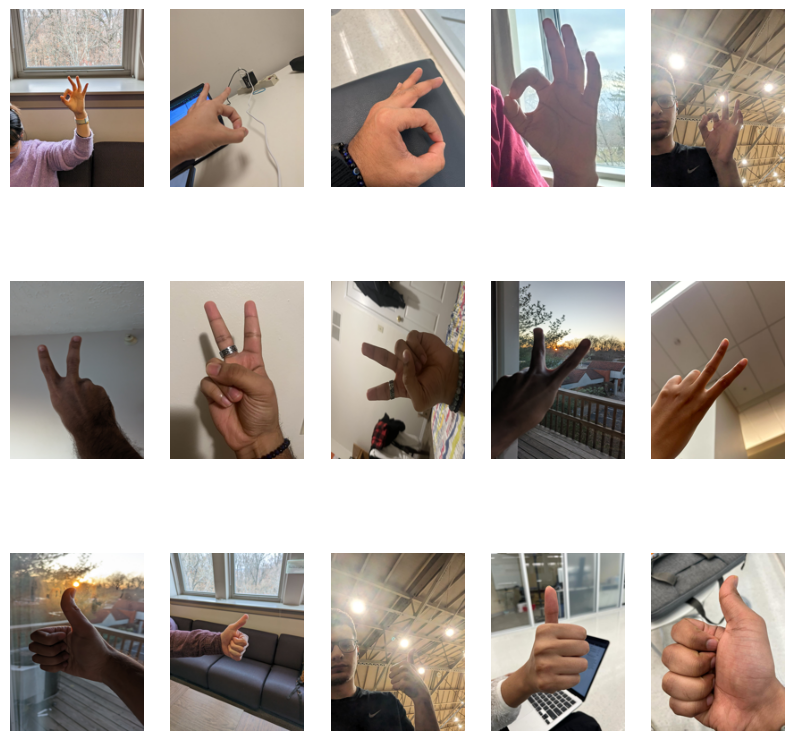

In [8]:
fig, ax = plt.subplots(3, 5, figsize=(10, 10))

image_set = O_index[:5] + P_index[:5] + T_index[:5]

for i,j in enumerate(image_set):
  y = i%5
  x = i//5
  ax[x,y].imshow(hand_gestures_image[j])
  ax[x,y].axis("off")

plt.show()

## Splitting into train, test, validation set

In [9]:
test = []
train = []
val = []

for i in range(len(hand_gestures_class)):
  number = random.randint(1,100)
  if number <= 60:
    train.append(i)
  elif number <= 80:
    test.append(i)
  else:
    val.append(i)

test_images = [hand_gestures_image[i] for i in test]
test_labels = [hand_gestures_class[i] for i in test]

train_images = [hand_gestures_image[i] for i in train]
train_labels = [hand_gestures_class[i] for i in train]

val_images = [hand_gestures_image[i] for i in val]
val_labels = [hand_gestures_class[i] for i in val]

print(f"Training set size: {len(train_images)}")
print(f"Validation set size: {len(val_images)}")
print(f"Test set size: {len(test_images)}")

Training set size: 189
Validation set size: 57
Test set size: 54


## Build the input pipeline and adding data augmentation.

In [10]:
warnings.filterwarnings("ignore")

In [11]:
class HandGesturesDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

In [12]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [13]:
train_dataset = HandGesturesDataset(images=train_images, labels=train_labels, transform=train_transform)
val_dataset = HandGesturesDataset(images=val_images, labels=val_labels, transform=val_transform)
test_dataset = HandGesturesDataset(images=test_images, labels=test_labels, transform=test_transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

## Fine-tuning a pre-trained model

#### Fine-tuning the model

In [14]:
model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [15]:
def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    pixel_values = torch.stack(pixel_values)
    labels = torch.tensor(labels, dtype=torch.long)

    return {'pixel_values': pixel_values, 'labels': labels}

In [16]:
metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [17]:
labels = [0, 1, 2]

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
training_args = TrainingArguments(
  output_dir="./vit-base-beans",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=50,
  fp16=False,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [19]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=processor,
)

In [20]:
train_results = trainer.train()

Step,Training Loss,Validation Loss,Accuracy
100,0.264700,0.308109,0.877193
200,0.197400,0.198092,0.894737
300,0.139300,0.412234,0.859649
400,0.079900,0.168882,0.947368
500,0.076500,0.054891,0.982456
600,0.044400,0.109168,0.947368


## Report classification accuracy

In [21]:
train_results

TrainOutput(global_step=600, training_loss=0.18647723163167634, metrics={'train_runtime': 396.6049, 'train_samples_per_second': 23.827, 'train_steps_per_second': 1.513, 'total_flos': 7.323058652249088e+17, 'train_loss': 0.18647723163167634, 'epoch': 50.0})

In [22]:
test_results = trainer.evaluate(test_dataset)

In [23]:
test_results

{'eval_loss': 0.1166505515575409,
 'eval_accuracy': 0.9814814814814815,
 'eval_runtime': 0.8584,
 'eval_samples_per_second': 62.908,
 'eval_steps_per_second': 8.155,
 'epoch': 50.0}

In [24]:
print(f'Test Accuracy: {test_results["eval_accuracy"] * 100:.2f}%')

Test Accuracy: 98.15%


Precision: 0.9826
Recall: 0.9815
F1 Score: 0.9815


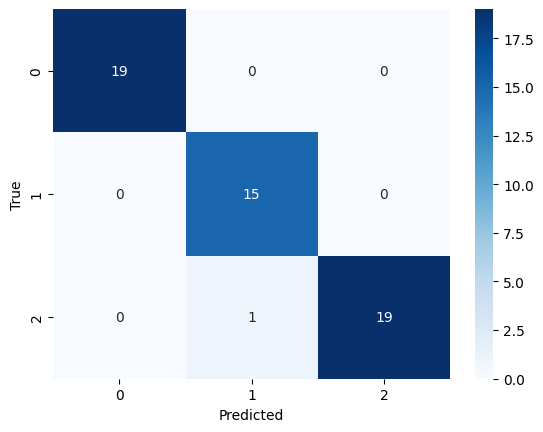

In [25]:
test_results = trainer.predict(test_dataset)
true_labels = np.array(test_dataset.labels)
predicted_labels = np.argmax(test_results.predictions, axis=1)

#true_labels = test_results.label_ids

# precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

labels = [0, 1, 2]
# confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Examples of correct/incorrect classification


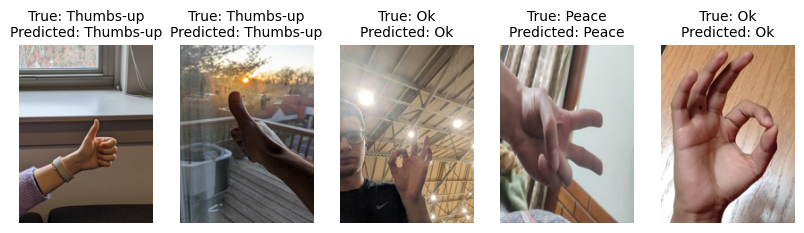

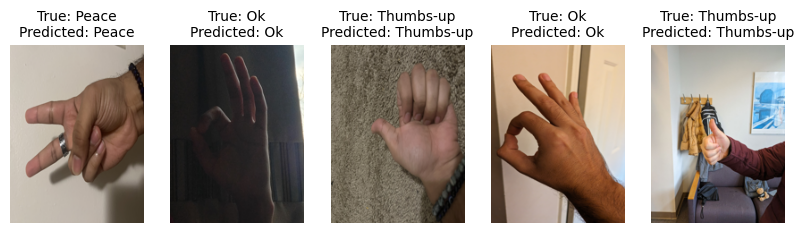

In [26]:
num_examples = 10
num_cols = 5
random_indices = random.sample(range(len(true_labels)), num_examples) # random indices for examples

for i in range(0, num_examples, num_cols):
    fig, axes = plt.subplots(1, num_cols, figsize=(10, 5))

    for j in range(num_cols):
        idx = random_indices[i + j]
        true_label = true_labels[idx]
        predicted_label = predicted_labels[idx]
        prediction_probabilities = test_results.predictions[idx]

        image = test_dataset.images[idx]
        axes[j].imshow(image)
        true_gesture = {0: 'Ok', 1: 'Peace', 2: 'Thumbs-up'}.get(true_label)
        predicted_gesture = {0: 'Ok', 1: 'Peace', 2: 'Thumbs-up'}.get(predicted_label)

        axes[j].set_title(f'True: {true_gesture}\nPredicted: {predicted_gesture}', fontsize=10)
        axes[j].axis('off')

    plt.show()

## Building a custom model, reporting accuracy and examples

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models

# Define a simple convolutional neural network
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Initialize the model, loss function, and optimizer
num_classes = len(set(hand_gestures_class))
custom_cnn_model = CustomCNN(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_cnn_model.parameters(), lr=0.001)

# Convert the data to PyTorch tensors
train_images_tensor = torch.tensor(train_images)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)

# Create a DataLoader for training
train_dataset = torch.utils.data.TensorDataset(train_images_tensor, train_labels_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)


num_epochs = 10
for epoch in range(num_epochs):
    custom_cnn_model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for images, labels in train_loader:
        optimizer.zero_grad()

        # Transpose images to [batch_size, channels, height, width]
        images = images.permute(0, 3, 1, 2).float()

        outputs = custom_cnn_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    # Calculate accuracy
    accuracy = correct_predictions / total_samples

    # Print training statistics
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [1/10], Loss: 175.8534, Accuracy: 0.3757
Epoch [2/10], Loss: 12.7489, Accuracy: 0.3704
Epoch [3/10], Loss: 3.8702, Accuracy: 0.3862
Epoch [4/10], Loss: 3.3531, Accuracy: 0.3439
Epoch [5/10], Loss: 3.2198, Accuracy: 0.3651
Epoch [6/10], Loss: 3.1596, Accuracy: 0.4074
Epoch [7/10], Loss: 3.4653, Accuracy: 0.3862
Epoch [8/10], Loss: 3.0452, Accuracy: 0.4656
Epoch [9/10], Loss: 2.9702, Accuracy: 0.4497
Epoch [10/10], Loss: 2.9437, Accuracy: 0.5291


In [55]:
correctly_classified_images = []
incorrectly_classified_images = []

custom_cnn_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        #images = images.permute(0, 3, 1, 2).float()
        outputs = custom_cnn_model(images)
        _, predicted = torch.max(outputs, 1)

        # Check if the prediction is correct
        correct_mask = predicted == labels

        # Append images to the correct list based on correct or incorrect classification
        correctly_classified_images.extend(images[correct_mask])
        incorrectly_classified_images.extend(images[~correct_mask])

In [29]:
predicted_label

[tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 2, 1, 1, 2, 1, 1, 1,
         1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 0, 2, 1, 1, 1, 1, 1, 0, 2, 1, 0, 2, 0, 1,
         1, 2, 1, 1, 1, 1])]

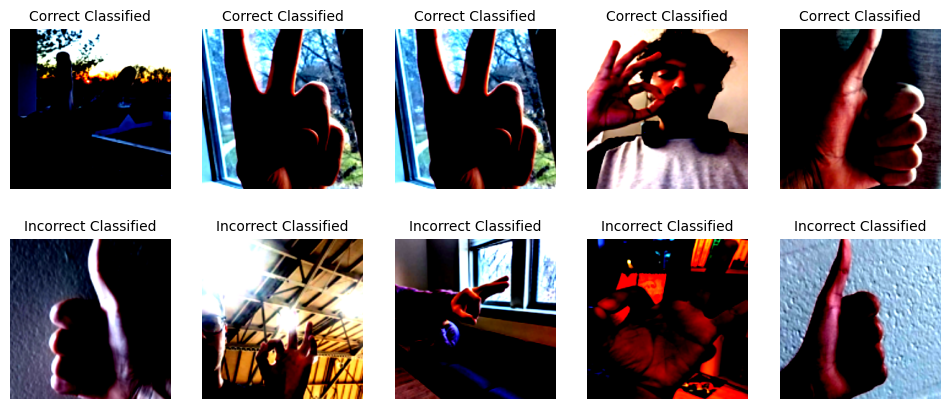

In [56]:
# Display a 2x5 grid with 5 random correctly and 5 random incorrectly classified images
num_examples = 5
fig, axes = plt.subplots(2, num_examples, figsize=(12, 5))

# Display randomly selected correctly classified images
for i in range(num_examples):
  num = random.randint(0, len(correctly_classified_images) - 1)
  img = correctly_classified_images[num]
  img = img.permute(1, 2, 0) #/ 255.0  # Normalize to [0, 1]

  axes[0, i].set_title(f'Correct Classified', fontsize=10)

  axes[0, i].imshow(img)
  axes[0, i].axis('off')

# Display randomly selected incorrectly classified images
for i in range(num_examples):
  num = random.randint(0, len(incorrectly_classified_images) - 1)
  img = incorrectly_classified_images[num]
  img = img.permute(1, 2, 0) #/ 255.0  # Normalize to [0, 1]

  axes[1, i].set_title(f'Incorrect Classified', fontsize=10)

  axes[1, i].imshow(img)
  axes[1, i].axis('off')

plt.show()